# PRIMO - The P&A Project Optimizer
## Workflow Demo 

This notebook contains a demo of PRIMO - The P&A Project Optimizer. Utilizing the workflow in the image below, PRIMO reads in  input data on marginal wells and their characteristics and analyzes it with respect to **USER-DEFINED PRIORITIES AND PREFERENCES** to provide recommendations on the design of impactful and efficient P&A projects. 

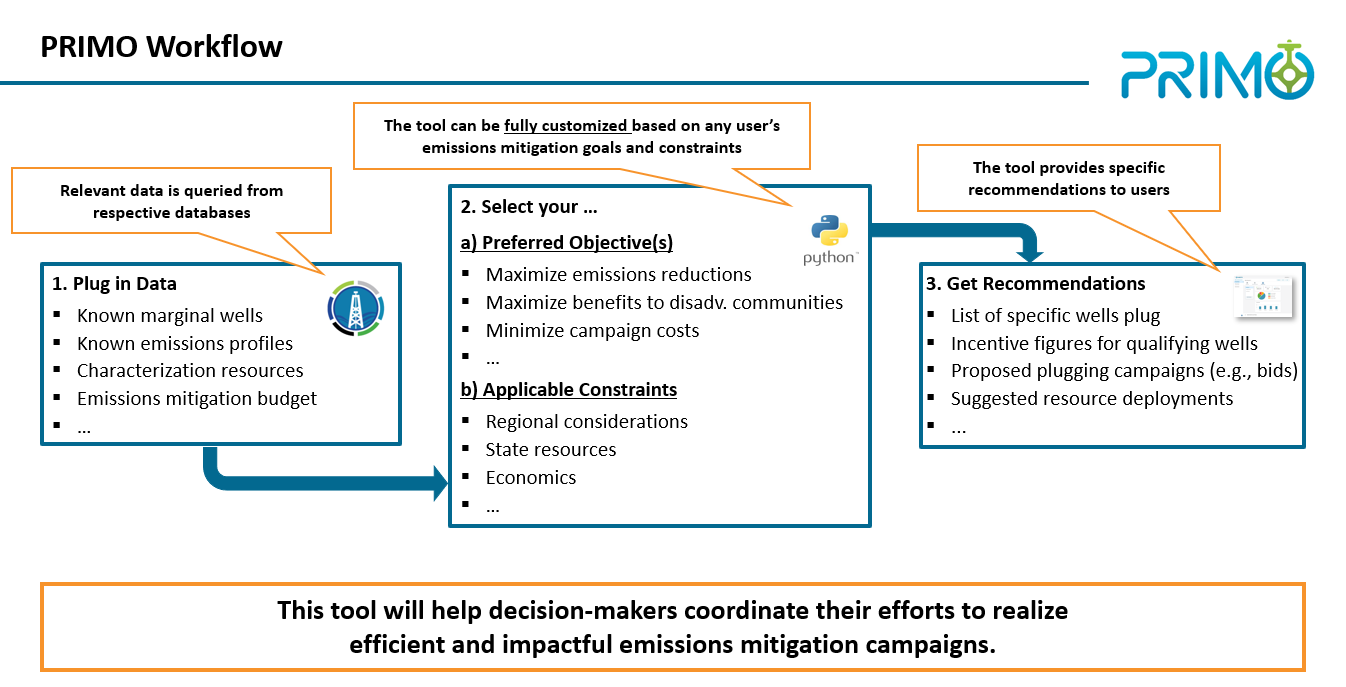

## Priority & Weight Selection Guidelines

Please use the following guidelines when selecting your priorities and their respective weights:
- Use the checkboxes to select preferred priorities and the respective sliders to specify the weight of these 
- Some priorities may also allow for the specification of sub-priorities (e.g., the sensitive receptors priority involves 8 sub-priorities: schools, hospitals, buildings, etc.).
- Use the checkbox to select a sub-priority and the corresponding slider to specify the weight of the sub-priority
- A sub-priority can only be selected if the corresponding "parent" priority has been selected
- The sum of all priorities needs to be 100
- The sum of all sub-priorities within each priority needs to be 100
- If you wish to change the weights after confirming them or getting an error, please re-run this cell in order to get a fresh start

## Using Config File to Provide Inputs

PRIMO utilizes a .json config file to define priority metrics, efficiency metrics, and constraints. Users can also specify default paths for input data files and output files. The current demo includes a config file - config_example.json. For detailed guidance on the purpose, construction, and modification of the config file, please refer to the documentation [Config File](https://primo.readthedocs.io/en/.html). (This link needs to be updated once the documentation is connected to readthedocs)

## Notice

This demo uses randomized data on a 2-d grid (x and y coordinates). Here, the x-coordinate represents the latitude, and the y-coordinate represents the longitude of a well. The demo results are accordingly visualized in scatter plots. 

PRIMO is designed to process geospatial data containing latitude and longitude information such as shapefiles and also queries data from external sources such as U.S. Census. PRIMO also has utilities available to plot visualizations using maps instead of 2-d grids. 

This notebook is primarily meant to showcase the workflow and functionality of PRIMO. PRIMO is under active development: please reach out to primo@netl.doe.gov for questions, comments, feedback or feature requests.

In [1]:
# Imports from installed libraries
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# PRIMO imports
from primo.data_parser import (
    EfficiencyMetrics,
    ImpactMetrics,
    WellData,
    WellDataColumnNames
)
from primo.opt_model.result_parser import (
    EfficiencyCalculator,
    export_data_to_excel
)
from primo.opt_model.model_options import OptModelInputs
from primo.utils import setup_logger
from primo.utils.map_utils import get_cluster_colors

# Setup logger
setup_logger()

## Impact Metric Selection

In [ ]:
# Define impact metrics by creating an instance of ImpactMetrics class
im_metrics = ImpactMetrics()

# Specify weights
im_metrics.set_weight(
    primary_metrics={
        "ch4_emissions": 35,
        "sensitive_receptors": 20,
        "ann_production_volume": 20,
        "well_age": 15,
        "well_count": 10,
    },
    submetrics={
        "ch4_emissions": {
            "leak": 40,
            "compliance": 30,
            "violation": 20,
            "incident": 10,
        },
        "sensitive_receptors": {
            "schools": 50,
            "hospitals": 50,
        },
        "ann_production_volume": {
            "ann_gas_production": 50,
            "ann_oil_production": 50,
        }
    }
)

# Check if the weights are valid or not
im_metrics.check_validity()

print(im_metrics)

In [ ]:
# (OPTIONAL) Metrics/submetrics that are not required can be deleted.
# This is an optional step. As long as their weight is set to zero, metric/submetrics
# that are not needed can still remain in the im_metrics object.
im_metrics.delete_metric("dac_impact")  # Deletes the metric as well submetrics "fed_dac" and "state_dac"
im_metrics.delete_metric("other_emissions")
im_metrics.delete_metric("five_year_production_volume")
im_metrics.delete_metric("well_integrity")
im_metrics.delete_metric("environment")

# Submetrics can also be deleted in a similar manner
im_metrics.delete_submetric("buildings_near")
im_metrics.delete_submetric("buildings_far")

print(im_metrics)

In [4]:
# # Alternatively, use the widget to set weights
# im_metrics_widget = im_metrics.build_widget()
# im_metrics_widget.display()

In [5]:
# # Update weights from the widget
# im_metrics.set_weight_from_widget(im_metrics_widget)

## Efficiency Metric Selection

In [ ]:
# Efficiency metrics can be set in a similar manner
eff_metrics = EfficiencyMetrics()

# Set weights for the metrics
eff_metrics.set_weight(
    primary_metrics={
        "num_wells": 20,
        "avg_dist_to_centroid": 30,
        "avg_elevation_delta": 20,
        "age_range": 10,
        "depth_range": 20,
    }
)

# Check validity of the metrics
eff_metrics.check_validity()

# Print the updated metrics
print(eff_metrics)

In [7]:
# # # Set weights using the widget
# eff_metrics_widget = eff_metrics.build_widget()
# eff_metrics_widget.display()

In [8]:
# # # Update weights from the widget
# eff_metrics.set_weight_from_widget(eff_metrics_widget)

## Read Well Data

In [ ]:
# Construct an object to store column names
col_names = WellDataColumnNames(
    well_id="API Well Number",
    latitude="x",
    longitude="y",
    operator_name="Operator Name",
    age="Age [Years]",
    depth="Depth [ft]",

    leak="Leak [Yes/No]",
    compliance="Compliance [Yes/No]",
    violation="Violation [Yes/No]",
    incident="Incident [Yes/No]",

    hospitals="Number of Nearby Hospitals",
    schools="Number of Nearby Schools",

    ann_gas_production="Gas [Mcf/Year]",
    ann_oil_production="Oil [bbl/Year]",
    
    # These are user-specific columns
    additional_columns={
        "elevation_delta": "Elevation Delta [m]",
        "dist_to_road": "Distance to Road [miles]",
    },
)

# Create the well data object
wd = WellData(data="Example_1_data.csv", column_names=col_names)

### MCW Population Visualization

In [ ]:
# Split the data data as oil and gas wells
gas_oil_wells = wd.get_gas_oil_wells

# Visualize wells
gas_wells = gas_oil_wells["gas"]   # WellData object
oil_wells = gas_oil_wells["oil"]   # WellData object

well_figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.scatter(gas_wells.data["x"], gas_wells.data["y"], c='r', marker="o")
ax1.set_title('Gas Wells')
ax1.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')
ax2.scatter(oil_wells.data["x"], oil_wells.data["y"], c='b', marker="X")
ax2.set_title('Oil Wells')
ax2.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')
plt.show()

### Capability 1: Prioritizing Wells
The number of wells under consideration is significantly larger than what can be plugged with the budget available. Hence, we prioritize wells as per user-defined priorities to rank the candidate pool of wells.

In [ ]:
# Compute priority scores of gas wells
gas_wells.compute_priority_scores(impact_metrics=im_metrics)


In [ ]:
# Compute priority scores of oil wells
oil_wells.compute_priority_scores(impact_metrics=im_metrics)

#### Outstanding: Filtering by MERP Volunteers

The MERP is a voluntary program for well owners.

#### Displaying High-Priority Wells

After applying all previously selected priority calculations, we display the highest-scoring wells below.


In [ ]:
display(Markdown(
"""
#### Gas Wells by Priority Scores
"""
))

# List of columns to display
cols_to_display = [
    col_names.well_id, col_names.operator_name, col_names.age, col_names.depth, "Priority Score [0-100]"
]

top_gas_wells = gas_wells.data.sort_values(by="Priority Score [0-100]", ascending=False)
display(top_gas_wells[cols_to_display].head(10))

In [ ]:
display(Markdown(
"""
#### Oil Wells by Priority Scores
"""
))

top_oil_wells = oil_wells.data.sort_values(by="Priority Score [0-100]", ascending=False)
display(top_oil_wells[cols_to_display].head(10))

## Capability 2: Budget-Specific P&A Projects Optimization 
To determine high-impact, high-efficiency P&A within the available budget, we use an optimization model. The optimization carefully evaluates all possible combinations of wells for plugging projects and helps us select the best campaigns in a data-based, transparent and defensible way.

The goal of the optimization is to seek those P&A projects that are not only impactful but will also lead to the most efficient use of P&A resources. The impact of a P&A project is determined by the priority scores of the wells contained within (as per the calculations outline above). More information on the definition and calculation of the predicted efficiency of a P&A project is provided below.

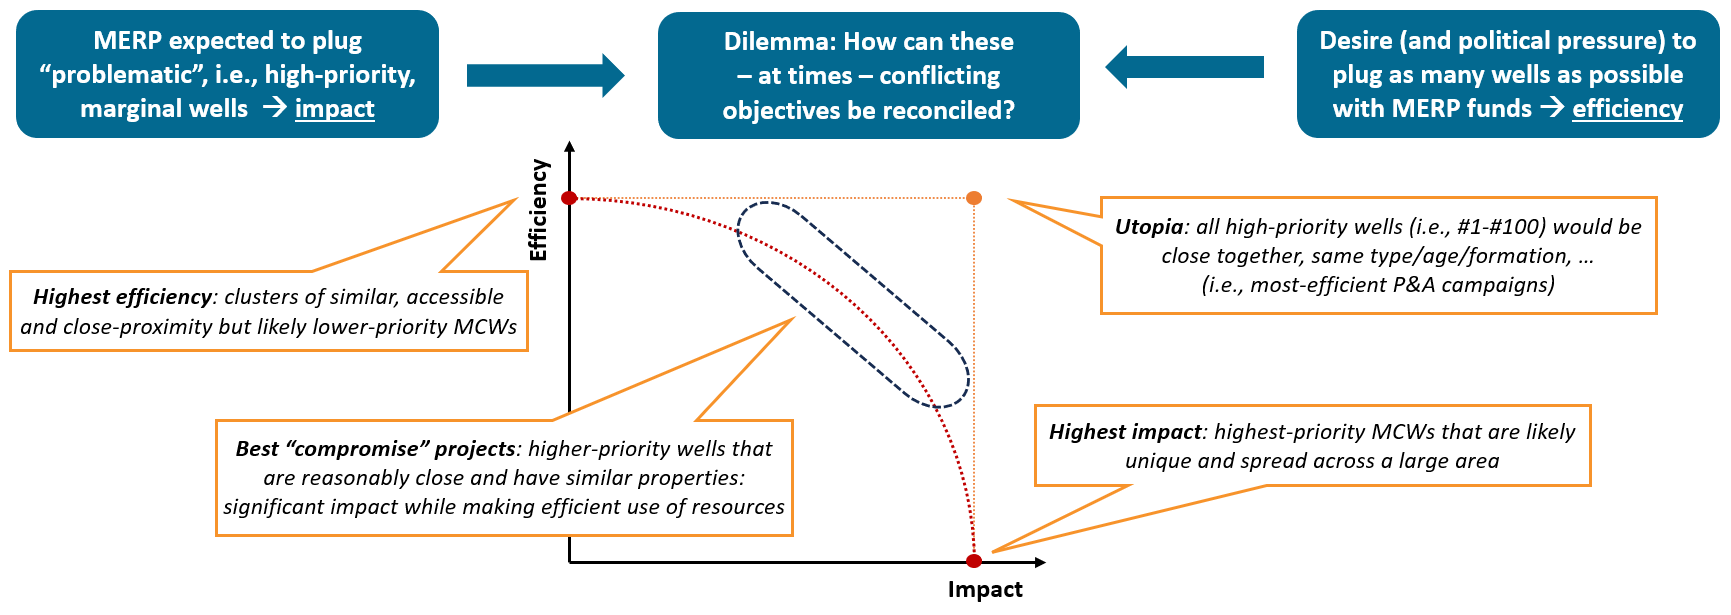

### State-Wide Program Constraints

In [ ]:
max_wells_per_owner = 1  #
threshold_distance = 10  # [in miles]
total_budget = 7.5e6     # USD

# Mobilization cost: Assumed to be same for both gas and oil wells
max_num_wells = max([len(gas_wells.data), len(oil_wells.data)])
mobilization_cost = {1: 120000, 2: 210000, 3: 280000, 4: 350000}
for n_wells in range(5, max_num_wells + 1):
    mobilization_cost[n_wells] = n_wells * 84000

# Split the total budget proportionately between gas and oil wells
gas_budget = total_budget * (
    # Fraction of gas wells in the dataset
    len(gas_wells.data) / (len(oil_wells.data) + len(gas_wells.data))
)
oil_budget = total_budget * (
    # Fraction of oil wells in the dataset
    len(oil_wells.data) / (len(oil_wells.data) + len(gas_wells.data))
)

# Set inputs for the optimization models
gas_model_inputs = OptModelInputs(
    well_data=gas_wells,
    total_budget=gas_budget,
    mobilization_cost=mobilization_cost,
    threshold_distance=threshold_distance,
    max_wells_per_owner=max_wells_per_owner,
)

oil_model_inputs = OptModelInputs(
    well_data=oil_wells,
    total_budget=oil_budget,
    mobilization_cost=mobilization_cost,
    threshold_distance=threshold_distance,
    max_wells_per_owner=max_wells_per_owner,
)

### Clustering Wells to Identify High-Impact, High-Efficiency P&A Candidate Projects
At present, wells are clustered based on proximity and similarity in characteristics (e.g. well age) so they can be organized into IMPACTFUL and EFFICIENT P&A projects. To identify groups of wells that would form a promising set for a project, we apply a constrained clustering algorithm.

In [ ]:
# Use the oil_gdf and gas_gdf pointers defined above
cluster_col_name = "Clusters"
n_clusters_gas = len(set(gas_wells.data[cluster_col_name]))  # Number of clusters of gas wells
n_clusters_oil = len(set(oil_wells.data[cluster_col_name]))  # Number of clusters of oil wells

color_list_oil = get_cluster_colors(n_clusters_oil, pd.unique(oil_wells.data[cluster_col_name]))
color_list_gas = get_cluster_colors(n_clusters_gas, pd.unique(gas_wells.data[cluster_col_name]))

# Scatter plot of clusters
cluster_figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for cluster in color_list_gas:
    gas_cluster = gas_wells.data[gas_wells.data[cluster_col_name] == cluster]
    ax1.scatter(
        gas_cluster[col_names.latitude],
        gas_cluster[col_names.longitude],
        c=color_list_gas[cluster],
    )

ax1.set_title('Gas Well Clusters')
ax1.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')

for cluster in color_list_oil:
    oil_cluster = oil_wells.data[oil_wells.data[cluster_col_name] == cluster]
    ax2.scatter(
        oil_cluster[col_names.latitude],
        oil_cluster[col_names.longitude],
        c=color_list_oil[cluster],
    )

ax2.set_title('Oil Well Clusters')
ax2.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')
plt.show()

### Optimizing for P&A Gas Projects 

In [ ]:
gas_model_inputs.build_optimization_model()
opt_campaign_gas = gas_model_inputs.solve_model(solver="scip")

### Optimizing for P&A Oil Projects

In [ ]:
oil_model_inputs.build_optimization_model()
opt_campaign_oil = oil_model_inputs.solve_model(solver="scip")

### RESULT: Summary of PRIMO-Recommended High-Impact, High-Efficiency P&A Gas Projects

In [ ]:
opt_campaign_gas.set_efficiency_weights(eff_metrics)
opt_campaign_gas.compute_efficiency_scores()

In [ ]:

#results for optimal projects for gas
print(opt_campaign_gas)

In [ ]:
opt_campaign_gas.plot_campaign(title="Location of Gas Wells in Campaign")

In [ ]:
# display the information for each project
for project_id, project_data in opt_campaign_gas.get_project_well_information().items():
    display(f"Well information for Project {project_id} with efficiency score : {opt_campaign_gas.get_efficiency_score_project(project_id)}")
    display(project_data)

### RESULT: Summary of PRIMO-Recommended High-Impact, High-Efficiency P&A Oil Projects

In [ ]:
opt_campaign_oil.set_efficiency_weights(eff_metrics)
opt_campaign_oil.compute_efficiency_scores()

In [ ]:
opt_campaign_oil.plot_campaign(title="Location of Oil Wells in Campaign")

In [ ]:
for project_id, project_data in opt_campaign_gas.get_project_well_information().items():
    display(f"Well information for Project {project_id} with efficiency score : {opt_campaign_gas.get_efficiency_score_project(project_id)}")
    display(project_data)

# Capability 3: P&A Project Efficiency Assessments
Ideal P&A projects not only include (many) high-priority wells but also prioritize the efficient use of available resources (e.g., budget, crews, equipment, ...). PRIMO has been designed to quantify the expected IMPACT and EFFICIENCY of recommended P&A candidate projects.

We employ a series of user-defined functions to calculate essential KPIs for each proposed P&A project.

- **Number of Wells**: The more wells a P&A project includes, the the more efficient plugging operations are expected to be - especially if the respective wells are close to each other. Note that upper limits on the number of wells per project may be imposed. Counted as the total number of wells associated with each project.

- **Well Proximities**: This KPI quantifies the "compactness" of any given P&A project. Wells close to each other lead to efficient plugging projects (e.g., reduced mobilization costs/efforts). Defined as the average absolute distance from well locations to the centroid of the project cluster.

- **Well Accessibility - Road Access**: The distance of any well to the closest road access point is used as a measure of well accessibility. The further a well is from any established road, the most costly it is presumed the P&A operation will be. Road construction cost can be significant contributor to project costs and efforts. Measured as the average absolute distance from well locations to their nearest road point. 

- **Well Accessibility - Elevation Change**: This KPI attempts to assess the accessibility of wells by comparing the elevation of the closest road access points to the elevation of the wells contained in a P&A project. If multiple wells in a project are characterized by significant elevation changes, they are presumed to be less accessible which increases P&A costs leading to inefficiencies. Computed as the average absolute elevation delta across all wells within the project group. The elevation delta is referred as the difference in surface elevation of the well and the elevation of the closest road access point. 

- **Well Characteristics - Age Range**: Wells with similar characteristics make for efficient P&A projects. As such, significant differences in well ages within a P&A project can pose challenges to P&A operations. The closer wells are in terms of age, the more efficient a P&A project is presumed to be. This metric Determined by subtracting the minimum age from the maximum age of wells within each P&A project. 

- **Well Characteristics - Depth Range**: Significant differences in well depths within a P&A project can pose challenges to P&A operations. The closer the wells are in terms of depth, the more efficient a P&A project is presumed to be. Calculated as the difference between the maximum and minimum depths of wells within the cluster. 

- **Number of Unique Well Owners**: As the number of (unique) well owners included in a given P&A project increases, so does the effort to manage a given project. Captured by counting the number of distinct company names associated with wells within each project. 

Upon computation of the KPIs for each P&A project, the next step is to scale these raw KPI values into standardized scores between 0 - 100 and then take the weighted average to calculate the **Efficiency Score** of the projects. 

## Efficiency Metrics for P&A Gas Projects

We calculate selected efficiency metrics for each plugging project:

In [ ]:
display(opt_campaign_gas.get_efficiency_metrics())

Scaling these raw KPI values into standardized scores between 0 - 100 and taking the weighted average to calculate the **Efficiency Score** of the projects.

The final IMPACT and EFFICIENCY scores of the gas plugging projects are shown below:

In [ ]:
display(opt_campaign_gas.get_campaign_summary())

## Efficiency Metrics for P&A Oil Projects

We calculate selected efficiency metrics for each plugging project:

In [ ]:
display(opt_campaign_oil.get_efficiency_metrics())

Scaling these raw KPI values into standardized scores between 0 - 100 and taking the weighted average to calculate the **Efficiency Score** of the projects.

The final IMPACT and EFFICIENCY scores of the oil plugging projects are shown below:

In [ ]:
display(opt_campaign_oil.get_campaign_summary())

## Saving PRIMO Results

We save the gas well and oil well projects in an excel file for each run. The default file name for the run is "Primo_Projects.xlsx".

In [30]:
output_file_path = "Primo_Projects.xlsx"
campaigns = [opt_campaign_gas, opt_campaign_oil]
campaign_labels = ["Gas", "Oil"]
export_data_to_excel(output_file_path, campaigns, campaign_labels)